# Description

## Learn LangChain in 60 Minutes — examples notebook

This is the **end-to-end** companion to `langchain.API.ipynb`.

If you’re brand new, it can help to skim the API notebook first so the names feel familiar.
Then come back here for the patterns that make things “click” in real apps.

What you’ll build (incrementally):
- a tool-calling agent loop
- LangGraph workflows: state, routing, reducers, and a ReAct loop from scratch
- subagents + subgraphs (composition)
- memory boundaries via checkpointers
- human-in-the-loop interrupts + resume
- Deep Agents demos (todos/filesystem/subagents/HITL/sandboxing)

Same note as the API notebook: some cells call an LLM (cost). It’s always okay to pause, read, and only run what you’re comfortable with.


# Imports

This notebook shares the same setup pattern as `langchain.API.ipynb`.

If you hit an import error in the next cell, you’re almost certainly running outside the tutorial environment.
The warm-and-fuzzy fix is: run from `tutorials/LangChain_LangGraph` with `requirements.txt` installed (or use Docker).


**This cell will:**
- Enable auto-reloading so edits are picked up without restarting the kernel.



In [33]:
%load_ext autoreload
%autoreload 2

import os
import sys
import importlib


def _require_import(module_name: str):
    try:
        return importlib.import_module(module_name)
    except ModuleNotFoundError as e:
        raise RuntimeError(
            f"""Missing Python package {module_name!r}.

This tutorial is meant to be run from `tutorials/LangChain_LangGraph` with its pinned dependencies.

Quick fixes:
- Docker (recommended): `cd tutorials/LangChain_LangGraph && docker compose up --build`
- Local venv: `cd tutorials/LangChain_LangGraph && pip install -r requirements.txt`
"""
        ) from e


langchain = _require_import("langchain")
langchain_core = _require_import("langchain_core")
langgraph = _require_import("langgraph")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**This cell will:**
- Configure logging and print environment/version info for debugging.



In [34]:
import logging
import platform

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(name)s - %(message)s")
_LOG = logging.getLogger("learn_langchain.examples")

_LOG.info("python=%s", sys.version.split()[0])
_LOG.info("platform=%s", platform.platform())
_LOG.info("langchain=%s", getattr(langchain, "__version__", "unknown"))
_LOG.info("langchain_core=%s", getattr(langchain_core, "__version__", "unknown"))
_LOG.info("langgraph=%s", getattr(langgraph, "__version__", "unknown"))
_LOG.info("LLM_PROVIDER=%s", os.getenv("LLM_PROVIDER", "(unset)"))


2026-02-05 21:53:52,364 INFO learn_langchain.examples - python=3.12.12
2026-02-05 21:53:52,365 INFO learn_langchain.examples - platform=Linux-6.10.14-linuxkit-aarch64-with-glibc2.41
2026-02-05 21:53:52,365 INFO learn_langchain.examples - langchain=1.2.8
2026-02-05 21:53:52,366 INFO learn_langchain.examples - langchain_core=1.2.8
2026-02-05 21:53:52,366 INFO learn_langchain.examples - langgraph=unknown
2026-02-05 21:53:52,367 INFO learn_langchain.examples - LLM_PROVIDER=openai


## Model (configured via `.env`)

We’ll reuse the same `.env`-driven model factory as the API notebook.

If you see an error about a missing env var, it’s almost always one of:
- `LLM_PROVIDER` not set
- the provider’s API key not set

Tip: start with a small/cheap model while you’re learning, then switch models later.


**This cell will:**
- Define a small `.env`-driven factory to create the chat model.



In [35]:
import os
from dataclasses import dataclass

from dotenv import load_dotenv

load_dotenv()


@dataclass(frozen=True)
class LlmConfig:
    """
    Configuration for selecting an LLM provider + model from environment variables.
    """

    provider: str
    model: str
    temperature: float


def _require_env(var_name: str) -> str:
    """
    Return the value of `var_name` from environment variables or raise.
    """
    value = os.getenv(var_name)
    if not value:
        raise RuntimeError(f"Missing required environment variable `{var_name}`. See `.env.example`.")
    return value


def load_llm_config() -> LlmConfig:
    """
    Load `LlmConfig` from environment variables.
    """
    provider = _require_env("LLM_PROVIDER").lower()
    temperature = float(os.getenv("LLM_TEMPERATURE", "0"))

    default_models = {
        "openai": "gpt-4.1-mini",
        "anthropic": "claude-3-5-sonnet-latest",
    }
    model = os.getenv("LLM_MODEL", default_models.get(provider, ""))
    if not model:
        raise RuntimeError(f"Missing `LLM_MODEL` for provider={provider!r}. See `.env.example`.")

    cfg = LlmConfig(provider=provider, model=model, temperature=temperature)
    return cfg


def get_chat_model():
    """
    Create a tool-calling-capable chat model using env configuration.
    """
    cfg = load_llm_config()

    if cfg.provider == "openai":
        from langchain_openai import ChatOpenAI

        _require_env("OPENAI_API_KEY")
        model = ChatOpenAI(
            model=cfg.model,
            temperature=cfg.temperature,
            timeout=60,
            max_retries=2,
        )
        return model

    if cfg.provider == "anthropic":
        from langchain_anthropic import ChatAnthropic

        _require_env("ANTHROPIC_API_KEY")
        model = ChatAnthropic(
            model=cfg.model,
            temperature=cfg.temperature,
            timeout=60,
            max_retries=2,
        )
        return model

    raise ValueError(
        f"Unsupported `LLM_PROVIDER={cfg.provider}`. Use one of: openai, anthropic."
    )


**This cell will:**
- Instantiate the chat model from your `.env` configuration.



In [36]:
llm = get_chat_model()
llm


ChatOpenAI(profile={'max_input_tokens': 1047576, 'max_output_tokens': 32768, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0xffff5753f530>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0xffff4c5dbdd0>, root_client=<openai.OpenAI object at 0xffff93f31010>, root_async_client=<openai.AsyncOpenAI object at 0xffff4c4528a0>, model_name='gpt-4.1-mini', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********'), request_timeout=60.0, stream_usage=True, max_retries=2)

## Local dataset (`data/T1_slice.csv`)

We keep the examples grounded by using a small CSV that lives in this folder.

Just like in the API notebook, we also copy it into `./workspace/data/` so that sandboxed filesystem tools can refer to it as `/workspace/data/T1_slice.csv`.


**This cell will:**
- Load the local dataset into a Pandas DataFrame and prepare the time column.
- Copy the dataset under `./workspace/data/` so Deep Agents can access it via `/workspace/...`.



In [37]:
from pathlib import Path
import shutil

import pandas as pd

DATASET_PATH = Path("data/T1_slice.csv").resolve()
df = pd.read_csv(DATASET_PATH)
TIME_COL = "Date/Time"
if TIME_COL in df.columns:
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], format="%d %m %Y %H:%M", errors="coerce")

# Make the dataset visible to Deep Agents filesystem tools under `/workspace/...`.
WORKSPACE_DIR = Path("workspace").resolve()
WORKSPACE_DATA_DIR = WORKSPACE_DIR / "data"
WORKSPACE_DATA_DIR.mkdir(parents=True, exist_ok=True)
WORKSPACE_DATASET_PATH = WORKSPACE_DATA_DIR / "T1_slice.csv"
if not WORKSPACE_DATASET_PATH.exists():
    shutil.copyfile(str(DATASET_PATH), str(WORKSPACE_DATASET_PATH))
df.head(5)


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


**This cell will:**
- Build compact, JSON-serializable metadata and sample rows to pass into prompts.



In [38]:
def build_dataset_meta(df) -> dict:
    '''
    Build a compact JSON-serializable dataset metadata dict for demos.
    '''
    cols = list(df.columns)
    dtypes = {c: str(df[c].dtype) for c in cols}
    sample_rows = df.head(3).to_dict(orient="records")
    freq = None
    if "Date/Time" in df.columns:
        ts = df["Date/Time"].dropna().sort_values()
        if len(ts) >= 3:
            # Estimate the most common sampling delta.
            deltas = ts.diff().dropna()
            freq = str(deltas.value_counts().idxmax())
    meta = {
        "path": "data/T1_slice.csv",
        "workspace_path": "workspace/data/T1_slice.csv",
        "tool_path": "/workspace/data/T1_slice.csv",
        "n_rows": int(df.shape[0]),
        "n_cols": int(df.shape[1]),
        "columns": cols,
        "dtypes": dtypes,
        "sample_rows": sample_rows,
        "time_col": "Date/Time" if "Date/Time" in df.columns else None,
        "freq": freq,
    }
    return meta

DATASET_META = build_dataset_meta(df)
DATASET_META


{'path': 'data/T1_slice.csv',
 'workspace_path': 'workspace/data/T1_slice.csv',
 'tool_path': '/workspace/data/T1_slice.csv',
 'n_rows': 100,
 'n_cols': 5,
 'columns': ['Date/Time',
  'LV ActivePower (kW)',
  'Wind Speed (m/s)',
  'Theoretical_Power_Curve (KWh)',
  'Wind Direction (°)'],
 'dtypes': {'Date/Time': 'datetime64[ns]',
  'LV ActivePower (kW)': 'float64',
  'Wind Speed (m/s)': 'float64',
  'Theoretical_Power_Curve (KWh)': 'float64',
  'Wind Direction (°)': 'float64'},
 'sample_rows': [{'Date/Time': Timestamp('2018-01-01 00:00:00'),
   'LV ActivePower (kW)': 380.047790527343,
   'Wind Speed (m/s)': 5.31133604049682,
   'Theoretical_Power_Curve (KWh)': 416.328907824861,
   'Wind Direction (°)': 259.994903564453},
  {'Date/Time': Timestamp('2018-01-01 00:10:00'),
   'LV ActivePower (kW)': 453.76919555664,
   'Wind Speed (m/s)': 5.67216682434082,
   'Theoretical_Power_Curve (KWh)': 519.917511061494,
   'Wind Direction (°)': 268.64111328125},
  {'Date/Time': Timestamp('2018-01-01 

## Quick EDA (local dataset)

A tiny bit of exploratory data analysis helps you trust the data you’re feeding into prompts.

We’ll do a quick look (head/describe/plot) so you can see:
- what columns exist
- what the time column looks like
- what “a reasonable question” about this dataset might be


**This cell will:**
- Run the next step of the end-to-end example.



shape: (100, 5)
columns: ['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']

missingness (top):
Date/Time                        0.0
LV ActivePower (kW)              0.0
Wind Speed (m/s)                 0.0
Theoretical_Power_Curve (KWh)    0.0
Wind Direction (°)               0.0
dtype: float64

summary stats (numeric):


,count,mean,std,min,25%,50%,75%,max
LV ActivePower (kW),100.0,893.159257,625.034034,41.947239,442.866859,740.190033,1147.448273,2820.512939
Wind Speed (m/s),100.0,6.534633,1.567091,3.253968,5.582957,6.426307,7.289940,10.772420
Theoretical_Power_Curve (KWh),100.0,942.250393,694.919714,29.286956,493.183982,777.472040,1152.040634,3186.029883
Wind Direction (°),100.0,240.518552,15.767294,199.848495,229.924049,236.154846,250.472420,274.232910


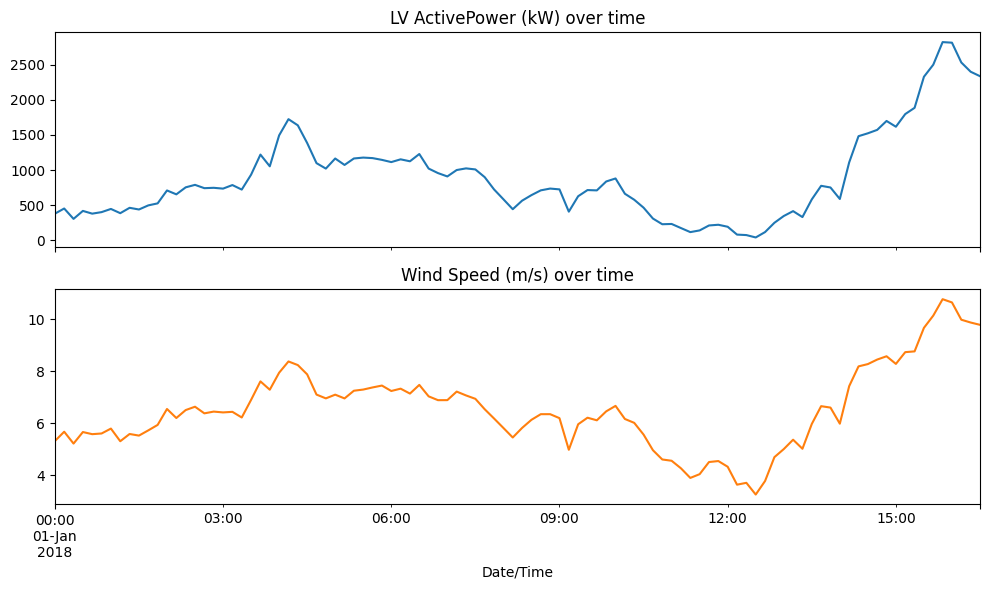

In [39]:
import matplotlib.pyplot as plt

print("shape:", df.shape)
print("columns:", list(df.columns))
print("\nmissingness (top):")
print((df.isna().mean() * 100).sort_values(ascending=False).head(10).round(2))

numeric_cols = [c for c in df.columns if c != "Date/Time"]
print("\nsummary stats (numeric):")
display(df[numeric_cols].describe().T)

if "Date/Time" in df.columns and pd.api.types.is_datetime64_any_dtype(df["Date/Time"]):
    cols = [c for c in ["LV ActivePower (kW)", "Wind Speed (m/s)"] if c in df.columns]
    if cols:
        ax = df.plot(
            x="Date/Time",
            y=cols,
            subplots=True,
            figsize=(10, 6),
            title=[f"{c} over time" for c in cols],
            legend=False,
        )
        plt.tight_layout()


## Basic tools (math + time)

Before we build agent loops, we’ll define a couple tiny tools.

Why start small?
- tools are just functions
- the schema is the contract
- the agent loop becomes much easier to understand when you already trust the tools


**This cell will:**
- Run the next step of the end-to-end example.



In [40]:
from datetime import datetime, timezone
import math

from langchain_core.tools import tool

@tool
def utc_now() -> str:
    """Return the current UTC time as an ISO string."""
    return datetime.now(timezone.utc).isoformat()

@tool
def mean(xs: list[float]) -> float:
    """Return the arithmetic mean of a non-empty list of numbers."""
    if not xs:
        raise ValueError("xs must be non-empty")
    return sum(float(x) for x in xs) / len(xs)

@tool
def sqrt(x: float) -> float:
    """Return sqrt(x)."""
    x = float(x)
    if x < 0:
        raise ValueError("x must be >= 0")
    return math.sqrt(x)


## Agent loop: `create_agent` + tool calling

This is the “hello world” of agentic behavior:

1) you give the model a goal
2) you give it tools
3) the model decides when to call tools vs when to answer directly

As you run the next cell, look for evidence of the loop in the message history:
- an AI message that requests a tool call
- a tool message that returns results
- a final AI message that uses those results


**This cell will:**
- Create a tool-calling agent using `create_agent(...)`.



In [41]:
from langchain_core.messages import HumanMessage
from langchain.agents import create_agent

agent = create_agent(
    model=llm,
    tools=[utc_now, mean, sqrt],
    system_prompt=(
        "You are a careful assistant. Use tools when computation or time is required. "
        "When you call a tool, use its output in your final answer."
    ),
)

inputs = {"messages": [HumanMessage(content="Compute mean([1,2,3,4,10]) and sqrt(49). Also tell me the current UTC time.")]}
final_state = agent.invoke(inputs)
[(type(m).__name__, getattr(m, "content", "")[:120]) for m in final_state["messages"]][-4:]


2026-02-05 21:53:53,814 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:53:55,990 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[('ToolMessage', '4.0'),
 ('ToolMessage', '7.0'),
 ('ToolMessage', '2026-02-05T21:53:53.822469+00:00'),
 ('AIMessage',
  'The mean of the list [1, 2, 3, 4, 10] is 4.0. The square root of 49 is 7.0. The current UTC time is 2026-02-05T21:53:53.')]

## LangGraph: StateGraph (hello)

LangGraph is a way to express workflows as a **stateful graph**.

If you’ve ever thought “I wish this agent had a clear structure and memory,” this is the tool.

A tiny checklist as you read the next cell:
- What does “state” look like? (a dict / TypedDict)
- What are the nodes? (functions that read + return updates)
- How do edges determine what runs next?


**This cell will:**
- Build and compile a `StateGraph` (a small LangGraph workflow).



In [42]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class S(TypedDict):
    n: int
    msg: str

def inc(state: S) -> dict:
    """Increment `state['n']` by 1."""
    return {"n": state.get("n", 0) + 1}

def set_msg(state: S) -> dict:
    """Set `state['msg']` to a string derived from the current counter."""
    return {"msg": f"n={state.get('n', 0)}"}

g = StateGraph(S)
g.add_node("inc", inc)
g.add_node("msg", set_msg)
g.add_edge(START, "inc")
g.add_edge("inc", "msg")
g.add_edge("msg", END)
graph = g.compile()

graph.invoke({"n": 0, "msg": ""})


{'n': 1, 'msg': 'n=1'}

## LangGraph: conditional routing

Graphs get interesting when the next step depends on state.

In this section you’ll see:
- a node returns an update
- a router looks at state and chooses the next node

This is the foundation for “if the model asked for a tool, run tools; otherwise, finish.”


**This cell will:**
- Build and compile a `StateGraph` (a small LangGraph workflow).



In [43]:
from typing import Literal

class R(TypedDict):
    flag: bool
    out: str

def a(state: R) -> dict:
    """Write a marker output for the `A` branch."""
    return {"out": "path=A"}

def b(state: R) -> dict:
    """Write a marker output for the `B` branch."""
    return {"out": "path=B"}

def route(state: R) -> Literal["a", "b"]:
    """Route based on the boolean `state['flag']`."""
    return "a" if state.get("flag") else "b"

g = StateGraph(R)
g.add_node("a", a)
g.add_node("b", b)
g.add_conditional_edges(START, route, {"a": "a", "b": "b"})
g.add_edge("a", END)
g.add_edge("b", END)
graph = g.compile()

graph.invoke({"flag": True, "out": ""}), graph.invoke({"flag": False, "out": ""})


({'flag': True, 'out': 'path=A'}, {'flag': False, 'out': 'path=B'})

## LangGraph: reducers (accumulate evidence)

Reducers are how you *accumulate* state across steps.

Common uses:
- collect “evidence” across iterations
- build up a list of intermediate results
- append messages rather than overwrite

In the next cell, focus on how state updates combine rather than replace.


**This cell will:**
- Build and compile a `StateGraph` (a small LangGraph workflow).



In [44]:
from typing import Annotated, List

def add_list(old: List[str], new: List[str]) -> List[str]:
    """Reducer that concatenates two evidence lists."""
    return old + new

class ReducerState(TypedDict):
    evidence: Annotated[List[str], add_list]

def find_missingness(_: ReducerState) -> dict:
    """Compute missingness findings from the local dataset."""
    miss = (df.isna().mean() * 100).sort_values(ascending=False)
    top = miss.head(3)
    evidence = [f"missingness: {idx} has {val:.2f}% missing" for idx, val in top.items()]
    return {"evidence": evidence}

def find_outliers(_: ReducerState) -> dict:
    """Compute a simple outlier finding using z-scores on one numeric column."""
    numeric_cols = [c for c in df.columns if c != "Date/Time"]
    col = None
    if "Wind Speed (m/s)" in df.columns:
        col = "Wind Speed (m/s)"
    elif numeric_cols:
        col = numeric_cols[0]
    if not col:
        return {"evidence": ["outliers: no numeric columns found"]}
    s = df[col].astype(float)
    mu = float(s.mean())
    sigma = float(s.std(ddof=0))
    if sigma == 0.0:
        return {"evidence": [f"outliers: std({col}) is 0, cannot compute z-scores"]}
    z = ((s - mu) / sigma).abs()
    idx = int(z.idxmax())
    ts = None
    if "Date/Time" in df.columns:
        ts = df.loc[idx, "Date/Time"]
    evidence = [f"outliers: max |z| for {col} at row={idx} ts={ts} value={s.loc[idx]:.3f} z={z.loc[idx]:.2f}"]
    return {"evidence": evidence}

g = StateGraph(ReducerState)
g.add_node("missingness", find_missingness)
g.add_node("outliers", find_outliers)
g.add_edge(START, "missingness")
g.add_edge("missingness", "outliers")
g.add_edge("outliers", END)
graph = g.compile()

graph.invoke({"evidence": []})["evidence"]


['missingness: Date/Time has 0.00% missing',
 'missingness: LV ActivePower (kW) has 0.00% missing',
 'missingness: Wind Speed (m/s) has 0.00% missing',
 'outliers: max |z| for Wind Speed (m/s) at row=95 ts=2018-01-01 15:50:00 value=10.772 z=2.72']

## ReAct loop from scratch: model node + ToolNode

ReAct (“Reason + Act”) is a simple pattern:

- the model thinks about what to do
- if it needs information, it calls a tool
- it repeats until it can answer

Here we build that loop explicitly with LangGraph:
- a model node that proposes tool calls
- a `ToolNode` that executes them
- routing logic that decides whether to continue looping

This is one of the best places to pause and say: “Ah — *this* is what an agent really is.”


**This cell will:**
- Build and compile a `StateGraph` (a small LangGraph workflow).
- Use `ToolNode` to execute tool calls inside a graph.



In [45]:
from typing import Annotated as Ann
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

class RS(TypedDict):
    messages: Ann[list, add_messages]

tools = [utc_now, mean, sqrt]
tool_node = ToolNode(tools)

def call_model(state: RS) -> dict:
    """Call the model with bound tools and append the AI message."""
    bound = llm.bind_tools(tools)
    ai = bound.invoke(state["messages"])
    return {"messages": [ai]}

def needs_tools(state: RS) -> str:
    """Route to tools if the last AI message contains tool calls."""
    last = state["messages"][-1]
    return "tools" if getattr(last, "tool_calls", None) else "end"

g = StateGraph(RS)
g.add_node("model", call_model)
g.add_node("tools", tool_node)
g.add_edge(START, "model")
g.add_conditional_edges("model", needs_tools, {"tools": "tools", "end": END})
g.add_edge("tools", "model")
graph = g.compile()

out = graph.invoke({"messages": [HumanMessage(content="Compute mean([1,2,3,4,10]) and sqrt(49). Also tell me the current UTC time.")]})
[(type(m).__name__, getattr(m, "content", "")[:120]) for m in out["messages"]][-4:]


2026-02-05 21:53:57,259 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:53:58,566 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


[('ToolMessage', '4.0'),
 ('ToolMessage', '7.0'),
 ('ToolMessage', '2026-02-05T21:53:57.264515+00:00'),
 ('AIMessage',
  'The mean of the list [1, 2, 3, 4, 10] is 4.0.\nThe square root of 49 is 7.0.\nThe current UTC time is 2026-02-05T21:53:57.')]

## Subagents: supervisor + worker tools

A helpful pattern is to split responsibilities:
- a **supervisor** decides what needs doing
- **workers** do specialized tasks (often via tools)

This keeps each piece simpler and makes debugging much easier.


**This cell will:**
- Create a tool-calling agent using `create_agent(...)`.



In [46]:
from langchain.tools import tool as lc_tool

def _last_text(result: dict) -> str:
    '''
    Return the final message text/content from an agent result state.
    '''
    msg = result["messages"][-1]
    return getattr(msg, "text", None) or getattr(msg, "content", None) or str(msg)

# E6.1: supervisor calls a worker wrapped as a tool
worker_agent = create_agent(
    llm,
    tools=[],
    system_prompt=(
        "You are a summarization specialist.\n"
        "Given text, return:\n"
        "- 1 sentence summary\n"
        "- 3 bullet key points\n"
        "Return only the summary + bullets."
    ),
)

@lc_tool("summarize_text", description="Summarize long text into a short summary + 3 bullet points.")
def summarize_text(text: str) -> str:
    '''
    Summarize `text` using the worker agent and return a plain string.
    '''
    return _last_text(worker_agent.invoke({"messages": [{"role": "user", "content": text}]}))

supervisor = create_agent(
    llm,
    tools=[summarize_text],
    system_prompt="If asked to summarize, call summarize_text and return the tool output.",
)

out = supervisor.invoke({"messages": [{"role": "user", "content": "Summarize: LangChain provides building blocks for LLM apps."}]})
_last_text(out)


2026-02-05 21:53:59,588 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:00,523 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:01,459 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'LangChain offers essential components for developing applications powered by large language models (LLMs). It provides modular building blocks that facilitate integration and management of language models, supporting the creation of complex and scalable LLM-based solutions.'

## Subagents: ToolRuntime state + Command(update=...)

Sometimes you want a tool to do more than return a value — you want it to update graph state.

In LangGraph that’s expressed with `Command(update=...)`.

You’ll also see `ToolRuntime`, which gives the tool access to useful runtime context (like the current state).


**This cell will:**
- Create a tool-calling agent using `create_agent(...)`.



In [47]:
import json
from typing_extensions import Annotated as TxAnnotated

from langchain.agents import AgentState
from langchain.tools import ToolRuntime, InjectedToolCallId
from langchain_core.messages import ToolMessage
from langgraph.types import Command

class CustomState(AgentState):
    user_prefs: dict
    facts: list[str]

worker = create_agent(llm, tools=[], system_prompt="Rewrite text. Return only rewritten text.")

@lc_tool("rewrite_with_prefs", description="Rewrite text following preferences from supervisor state.")
def rewrite_with_prefs(text: str, runtime: ToolRuntime[None, CustomState]) -> str:
    '''
    Rewrite `text` using supervisor preferences available via `runtime.state`.
    '''
    tone = runtime.state.get("user_prefs", {}).get("tone", "neutral")
    result = worker.invoke(
        {"messages": [{"role": "system", "content": f"Tone must be: {tone}."}, {"role": "user", "content": text}]}
    )
    return _last_text(result)

fact_worker = create_agent(llm, tools=[], system_prompt='Return ONLY JSON: {"facts": ["..."]}')

@lc_tool("extract_facts", description="Extract facts and update supervisor state via Command(update=...).")
def extract_facts(text: str, tool_call_id: TxAnnotated[str, InjectedToolCallId]) -> Command:
    '''
    Extract facts and store them in the supervisor state via `Command(update=...)`.
    '''
    raw = _last_text(fact_worker.invoke({"messages": [{"role": "user", "content": text}]}))
    try:
        facts = list(json.loads(raw).get("facts", []))
    except Exception:
        facts = [raw]
    return Command(
        update={
            "facts": facts,
            "messages": [ToolMessage(content=f"Stored {len(facts)} facts.", tool_call_id=tool_call_id)],
        }
    )

supervisor = create_agent(
    llm,
    tools=[rewrite_with_prefs, extract_facts],
    system_prompt="Use rewrite_with_prefs for rewrite requests; use extract_facts for 'read and explain'.",
    state_schema=CustomState,
)

out1 = supervisor.invoke(
    {
        "messages": [{"role": "user", "content": "Rewrite: please send me the report by tonight."}],
        "user_prefs": {"tone": "formal"},
        "facts": [],
    }
)
out2 = supervisor.invoke(
    {
        "messages": [{"role": "user", "content": "Read this and explain it: LangGraph supports interrupts."}],
        "user_prefs": {"tone": "neutral"},
        "facts": [],
    }
)

{"rewrite": _last_text(out1), "facts_updated": out2.get("facts")}


2026-02-05 21:54:02,170 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:02,731 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:03,633 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:04,327 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:04,912 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:06,346 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'rewrite': 'Kindly ensure that the report is sent to me by this evening.',
 'facts_updated': ['LangGraph supports interrupts.']}

**This cell will:**
- Create a tool-calling agent using `create_agent(...)`.



In [48]:
# E6.2: two subagents (date normalization + email drafting)
date_agent = create_agent(
    llm,
    tools=[],
    system_prompt='Return ONLY JSON: {"normalized": "...", "notes": "..."}',
)

@lc_tool("normalize_datetime", description="Normalize informal date/time mentions into an explicit format. Returns JSON.")
def normalize_datetime(request: str) -> str:
    '''
    Normalize an informal date/time request using a specialized subagent.
    '''
    return _last_text(date_agent.invoke({"messages": [{"role": "user", "content": request}]}))

email_agent = create_agent(
    llm,
    tools=[],
    system_prompt="Draft a short professional email body. Return only the email body.",
)

@lc_tool("draft_email_body", description="Draft a concise professional email body for a user request.")
def draft_email_body(request: str) -> str:
    '''
    Draft a short professional email body for `request`.
    '''
    return _last_text(email_agent.invoke({"messages": [{"role": "user", "content": request}]}))

sup = create_agent(llm, tools=[normalize_datetime, draft_email_body], system_prompt="Pick the right tool for the user's intent.")

a = sup.invoke({"messages": [{"role": "user", "content": "Normalize: next Tuesday at 2pm."}]})
b = sup.invoke({"messages": [{"role": "user", "content": "Write an email to my professor asking for a 2-day extension."}]})
{"normalize_datetime": _last_text(a), "draft_email_body": _last_text(b)}


2026-02-05 21:54:07,156 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:08,296 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:09,159 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:10,133 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:12,290 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:13,715 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'normalize_datetime': 'The normalized date and time for "next Tuesday at 2pm" is May 7, 2024, at 14:00 (2 PM).',
 'draft_email_body': 'Dear Professor [Last Name],\n\nI hope this message finds you well. I am writing to kindly request a two-day extension on the upcoming assignment due [original due date]. Due to unforeseen circumstances, I need a bit more time to complete the work to the best of my ability.\n\nI appreciate your understanding and consideration.\n\nBest regards,  \n[Your Name]'}

**This cell will:**
- Create a tool-calling agent using `create_agent(...)`.



In [49]:
# E6.3: context isolation (noisy worker, clean supervisor)
@lc_tool("generate_noise", description="Generate a long string to simulate noisy intermediate work.")
def generate_noise(n_chars: int) -> str:
    '''
    Generate a long string used to simulate irrelevant intermediate work.
    '''
    return "X" * int(n_chars)

noisy_worker_agent = create_agent(
    llm,
    tools=[generate_noise],
    system_prompt=(
        "You MUST call generate_noise with n_chars=8000 exactly once, then ignore it.\n"
        "Return ONLY a concise 2-sentence answer."
    ),
)

@lc_tool("noisy_worker", description="Do a task in an isolated context and return a concise final answer.")
def noisy_worker(task: str) -> str:
    '''
    Run `task` in an isolated subagent context and return the final answer.
    '''
    return _last_text(noisy_worker_agent.invoke({"messages": [{"role": "user", "content": task}]}))

sup = create_agent(llm, tools=[noisy_worker], system_prompt="Call noisy_worker for the user's request.")
out = sup.invoke({"messages": [{"role": "user", "content": "Explain in plain English what 'context isolation' means in subagents."}]})
_last_text(out)


2026-02-05 21:54:14,537 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:15,457 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:16,800 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:18,017 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


"Context isolation in subagents means keeping each subagent's information and environment separate so they don't interfere with or access each other's data. This ensures that each subagent operates independently and securely within its own context."

**This cell will:**
- Create a tool-calling agent using `create_agent(...)`.
- Demonstrate notebook operations (write/execute/parameterize notebooks).



In [50]:
# E6.6: parallel tool calls (one AI turn emits multiple tool calls)
sum_agent = create_agent(llm, tools=[], system_prompt="Summarize in 2 sentences. Return only the summary.")
act_agent = create_agent(llm, tools=[], system_prompt="Extract action items as bullets. Return only bullets.")
reply_agent = create_agent(llm, tools=[], system_prompt="Draft a short reply email. Return only the email body.")

@lc_tool("sub_summarize", description="Summarize the text in 2 sentences.")
def sub_summarize(text: str) -> str:
    '''
    Summarize `text` in 2 sentences.
    '''
    return _last_text(sum_agent.invoke({"messages": [{"role": "user", "content": text}]}))

@lc_tool("sub_action_items", description="Extract action items as bullet points.")
def sub_action_items(text: str) -> str:
    '''
    Extract action items from `text` as bullet points.
    '''
    return _last_text(act_agent.invoke({"messages": [{"role": "user", "content": text}]}))

@lc_tool("sub_draft_reply", description="Draft a short email reply addressing the content.")
def sub_draft_reply(text: str) -> str:
    '''
    Draft a short email reply based on `text`.
    '''
    return _last_text(reply_agent.invoke({"messages": [{"role": "user", "content": text}]}))

sup = create_agent(llm, tools=[sub_summarize, sub_action_items, sub_draft_reply], system_prompt="Use tools as needed and return a clean final response.")

email_thread = (
    "Call ALL THREE tools (sub_summarize, sub_action_items, sub_draft_reply). "
    "Text: We need to ship the notebook execution feature by Friday. Please confirm papermill works."
)
out = sup.invoke({"messages": [{"role": "user", "content": email_thread}]})
_last_text(out)


2026-02-05 21:54:20,170 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:20,827 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:21,157 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:21,259 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:23,400 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Summary:\nThe notebook execution feature must be shipped by Friday. Please verify that papermill is functioning correctly.\n\nAction Items:\n- Confirm that papermill works.\n- Ship the notebook execution feature by Friday.\n\nDraft Reply:\nI have tested papermill, and it is working as expected. We should be on track to ship the notebook execution feature by Friday. Let me know if you need any further verification.'

## Subgraphs (graph-as-node composition)

A subgraph is just a graph you treat like a node.

This is how you build larger systems without everything becoming one giant tangle:
- small graph for “extract facts”
- small graph for “summarize”
- parent graph that composes them


**This cell will:**
- Build and compile a `StateGraph` (a small LangGraph workflow).



In [51]:
class SubState(TypedDict):
    raw: str
    parsed: dict
    formatted: str

def parse_node(state: SubState) -> dict:
    """Parse `key: value` lines from `state['raw']` into a dict."""
    raw = state["raw"]
    parsed = {}
    for line in raw.splitlines():
        if ":" in line:
            k, v = line.split(":", 1)
            parsed[k.strip()] = v.strip()
    return {"parsed": parsed}

def format_node(state: SubState) -> dict:
    """Format the parsed fields as a bullet list."""
    parsed = state.get("parsed", {})
    lines = [f"- {k}: {v}" for k, v in parsed.items()]
    return {"formatted": "Parsed fields:\n" + "\n".join(lines)}

sub = StateGraph(SubState)
sub.add_node("parse", parse_node)
sub.add_node("format", format_node)
sub.add_edge(START, "parse")
sub.add_edge("parse", "format")
sub.add_edge("format", END)
subgraph = sub.compile()

class ParentState(TypedDict):
    user_text: str
    result: str

def call_subgraph(state: ParentState) -> dict:
    """Call `subgraph` and project its formatted output into the parent state."""
    out = subgraph.invoke({"raw": state["user_text"]})
    return {"result": out["formatted"]}

parent = StateGraph(ParentState)
parent.add_node("worker", call_subgraph)
parent.add_edge(START, "worker")
parent.add_edge("worker", END)
parent_graph = parent.compile()

parent_graph.invoke({"user_text": "name: Indro\nrole: ML engineer\nlocation: Kolkata", "result": ""})["result"]


'Parsed fields:\n- name: Indro\n- role: ML engineer\n- location: Kolkata'

## Shared vs private memory boundaries (checkpointers)

Checkpointers are how LangGraph remembers state across runs.

This section helps answer:
- what does `thread_id` do?
- when do two runs share memory vs start fresh?
- how do you keep different users/sessions isolated?

If you’ve ever debugged an agent that “remembered the wrong thing,” this is the antidote.


**This cell will:**
- Build and compile a `StateGraph` (a small LangGraph workflow).



In [52]:
from langgraph.checkpoint.memory import MemorySaver

class CSub(TypedDict):
    n: int

def bump(state: CSub) -> dict:
    """Increment a counter used to demonstrate subgraph memory behavior."""
    return {"n": state.get("n", 0) + 1}

sub_builder = StateGraph(CSub)
sub_builder.add_node("bump", bump)
sub_builder.add_edge(START, "bump")
sub_builder.add_edge("bump", END)

sub_shared = sub_builder.compile()
sub_private = sub_builder.compile(checkpointer=MemorySaver())

class P(TypedDict):
    mode: str
    sub_n: int

def call_sub(state: P) -> dict:
    """Call the shared or private subgraph depending on `state['mode']`."""
    if state["mode"] == "shared":
        out = sub_shared.invoke({"n": state.get("sub_n", 0)})
        return {"sub_n": out["n"]}
    out = sub_private.invoke({"n": 0}, config={"configurable": {"thread_id": "SUBGRAPH_THREAD"}})
    return {"sub_n": out["n"]}

parent_builder = StateGraph(P)
parent_builder.add_node("call_sub", call_sub)
parent_builder.add_edge(START, "call_sub")
parent_builder.add_edge("call_sub", END)
parent = parent_builder.compile(checkpointer=MemorySaver())

def run_twice(mode: str):
    """Invoke the parent graph twice and return the two observed sub-counters."""
    out1 = parent.invoke({"mode": mode, "sub_n": 0}, config={"configurable": {"thread_id": f"PARENT_{mode}"}})
    out2 = parent.invoke({"mode": mode, "sub_n": out1["sub_n"]}, config={"configurable": {"thread_id": f"PARENT_{mode}"}})
    return out1["sub_n"], out2["sub_n"]

run_twice("shared"), run_twice("private")


((1, 2), (1, 1))

## Human-in-the-loop gate (interrupt + resume)

HITL isn’t about slowing you down — it’s about making powerful agents *safe*.

In this section, the graph will:
- pause with an interrupt payload
- wait for a human decision
- resume using `Command(resume=...)`

If you’re wondering “where does the UI come from?” — great question.
LangGraph gives you the **primitive** (interrupt + resume). You can surface that in a notebook, a web app, Slack, etc.


**This cell will:**
- Build and compile a `StateGraph` (a small LangGraph workflow).
- Demonstrate human-in-the-loop control using `interrupt(...)` and resume.



In [53]:
from pathlib import Path
from typing import Literal as Lit

from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver

class HITLState(TypedDict):
    target_path: str
    decision: Lit["approve", "reject", ""]

def propose_delete(state: HITLState) -> dict:
    """Emit an interrupt asking for approval to delete `state['target_path']`."""
    payload = {"action": "delete_file", "target_path": state["target_path"], "message": "Approve deletion?"}
    decision = interrupt(payload)
    return {"decision": decision}

def do_delete(state: HITLState) -> dict:
    """Delete the file if the prior interrupt decision was `approve`."""
    if state["decision"] != "approve":
        return {}
    p = Path(state["target_path"])
    if p.exists() and p.is_file():
        p.unlink()
    return {}

builder = StateGraph(HITLState)
builder.add_node("propose", propose_delete)
builder.add_node("delete", do_delete)
builder.add_edge(START, "propose")
builder.add_edge("propose", "delete")
builder.add_edge("delete", END)

hitl_graph = builder.compile(checkpointer=MemorySaver())

tmp_dir = Path("tmp_runs").resolve()
tmp_dir.mkdir(parents=True, exist_ok=True)
victim = tmp_dir / "victim.txt"
victim.write_text("delete me", encoding="utf-8")

thread_id = "HITL_NOTEBOOK_DEMO"
out1 = hitl_graph.invoke({"target_path": str(victim), "decision": ""}, config={"configurable": {"thread_id": thread_id}})
pending = out1.get("__interrupt__", [])[0].value if "__interrupt__" in out1 else None
pending


{'action': 'delete_file',
 'target_path': '/app/tmp_runs/victim.txt',
 'message': 'Approve deletion?'}

**This cell will:**
- Run the next step of the end-to-end example.



In [54]:
out2 = hitl_graph.invoke(Command(resume="approve"), config={"configurable": {"thread_id": thread_id}})
victim.exists()


False

## Deep Agents (E7: DA1 → DA8)

Deep Agents is a compact “agent app” layer used in this tutorial.
It wraps common patterns (todos, filesystem tools, delegation) so you can focus on *behavior* rather than plumbing.

We’ll walk through DA1 → DA8 in small steps:
- DA1: Hello deep agent
- DA2: planning tool (`write_todos`)
- DA3: filesystem surface (`write_file` / `read_file`)
- DA4: backends matrix (State vs Filesystem vs Store)
- DA5: dict-based subagents (delegate via `task`)
- DA6: `CompiledSubAgent` (delegate to a compiled runnable)
- DA7: HITL gates (`interrupt_on` + `Command(resume=...)`)
- DA8: sandboxing (`FilesystemBackend(virtual_mode=True)`)

Two safety notes:
- filesystem demos write under `workspace/` and `tmp_runs/` in this folder
- HITL gates are what prevent “silent” edits when you want a human to approve


**This cell will:**
- Run a Deep Agents demo (filesystem/todos/subagents/HITL).



In [55]:
try:
    import deepagents  # type: ignore
    from deepagents import CompiledSubAgent, create_deep_agent  # type: ignore
    from deepagents.backends import (  # type: ignore
        CompositeBackend,
        FilesystemBackend,
        StateBackend,
        StoreBackend,
    )

    print("deepagents:", getattr(deepagents, "__version__", "(unknown)"))
except Exception as e:  # pragma: no cover
    raise RuntimeError(
        "Deep Agents section requires `deepagents`.\n"
        "Run this notebook via the provided Docker setup or install tutorial deps.\n"
        f"Import error: {type(e).__name__}: {str(e)[:200]}"
    )


deepagents: 0.3.11


**This cell will:**
- Run the next step of the end-to-end example.



In [56]:
import json
from pathlib import Path
from typing import Any

from langchain_core.messages import AIMessage, ToolMessage

def _all_tool_calls(messages: list[Any]) -> list[dict[str, Any]]:
    '''
    Collect tool call dicts emitted by `AIMessage` objects in `messages`.
    '''
    calls: list[dict[str, Any]] = []
    for m in messages:
        if isinstance(m, AIMessage):
            for tc in (m.tool_calls or []):
                if isinstance(tc, dict):
                    calls.append(tc)
    return calls

def _tool_outputs(messages: list[Any], tool_name: str) -> list[Any]:
    '''
    Return tool message contents for `tool_name`.
    '''
    outs: list[Any] = []
    for m in messages:
        if isinstance(m, ToolMessage) and getattr(m, "name", None) == tool_name:
            outs.append(m.content)
    return outs

def _as_text(x: Any) -> str:
    '''
    Convert `x` to a readable string for printing.
    '''
    if isinstance(x, str):
        return x
    return json.dumps(x, indent=2, ensure_ascii=False) if isinstance(x, (dict, list)) else str(x)

def _read_file_text(read_result: Any) -> str:
    '''
    Extract plain text from a `read_file` tool output.
    '''
    if read_result is None:
        return ""
    if isinstance(read_result, str):
        return read_result
    if isinstance(read_result, list):
        parts = [str(x) for x in read_result]
        return "\n".join(parts)
    if isinstance(read_result, dict):
        content = read_result.get("content")
        if isinstance(content, list):
            return "\n".join([str(x) for x in content])
        if isinstance(content, str):
            return content
        text = read_result.get("text")
        if isinstance(text, str):
            return text
    return _as_text(read_result)

def _extract_bullets(text: str) -> list[str]:
    '''
    Extract Markdown-style bullet lines from `text`.
    '''
    lines = []
    for ln in text.splitlines():
        s = ln.strip()
        if s.startswith("- ") or s.startswith("* "):
            lines.append("- " + s[2:].strip())
            continue
        if s.startswith("•"):
            lines.append("- " + s.lstrip("•").strip())
            continue
        if len(s) >= 3 and s[0].isdigit() and s[1] in (".", ")"):
            lines.append("- " + s[2:].strip())
            continue
        if len(s) >= 4 and s[0].isdigit() and s[1].isdigit() and s[2] in (".", ")"):
            lines.append("- " + s[3:].strip())
            continue
    return lines

def build_dataset_context() -> str:
    '''
    Build a compact dataset context string for prompts, if `DATASET_META` exists.
    '''
    meta = globals().get("DATASET_META", None)
    if not isinstance(meta, dict):
        return "Dataset context: (not loaded)."
    cols = meta.get("columns", [])
    sample_rows = meta.get("sample_rows", [])
    time_col = meta.get("time_col", None)
    freq = meta.get("freq", None)
    parts = [
        f"path={meta.get('path')}",
        f"tool_path={meta.get('tool_path')}",
        f"n_rows={meta.get('n_rows')}",
        f"n_cols={meta.get('n_cols')}",
        f"time_col={time_col}",
        f"freq={freq}",
        f"columns={cols}",
        f"sample_rows={sample_rows}",
    ]
    return "Dataset context:\\n" + "\\n".join(parts)

DATASET_CONTEXT = build_dataset_context()


### DA1 — Hello, deep agent

Goal: create the smallest possible Deep Agent and ask it a simple question.

You’re looking for:
- a normal chat response
- plus evidence that the agent is *tool-capable* (even if it doesn’t call a tool yet)


**This cell will:**
- Run a Deep Agents demo (filesystem/todos/subagents/HITL).



In [57]:
llm_da = get_chat_model()
agent = create_deep_agent(model=llm_da)
out = agent.invoke({"messages": [{"role": "user", "content": "In 3 bullets, explain what a deep agent is useful for."}]})
print("state keys:", sorted(list(out.keys()))[:20])
print("final message preview:", getattr(out["messages"][-1], "content", "")[:240])


2026-02-05 21:54:25,115 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


state keys: ['messages']
final message preview: - Deep agents are useful for handling complex, multi-step tasks that require thorough reasoning, planning, and execution beyond simple or single-step actions.
- They excel at isolating and managing independent subtasks within a larger objec


### DA2 — Planning tool: `write_todos`

Goal: show that the agent can produce a structured plan.

This is a gentle entry point into “agentic” behavior:
- break a task into steps
- keep the steps visible
- iterate as you go


**This cell will:**
- Run a Deep Agents demo (filesystem/todos/subagents/HITL).



In [58]:
agent = create_deep_agent(model=get_chat_model())
prompt = (
    "Before doing anything else, call write_todos with 5 EDA tasks for THIS dataset. "
    "Mark the first task as in_progress.\n\n"
    f"{DATASET_CONTEXT}\n\nIf you need raw rows, use read_file {DATASET_META.get('tool_path')}."
)
out = agent.invoke({"messages": [{"role": "user", "content": prompt}]})
todos = out.get("todos", None)
print("todos channel present:", todos is not None)
print(_as_text(todos)[:800])


2026-02-05 21:54:27,436 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:28,358 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:29,695 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


todos channel present: True
[
  {
    "content": "Load the dataset and check basic information (shape, data types, missing values)",
    "status": "in_progress"
  },
  {
    "content": "Perform summary statistics for numerical columns",
    "status": "pending"
  },
  {
    "content": "Visualize time series trends for 'LV ActivePower (kW)' and 'Wind Speed (m/s)'",
    "status": "pending"
  },
  {
    "content": "Analyze the distribution and correlation of numerical features",
    "status": "pending"
  },
  {
    "content": "Check for any anomalies or outliers in the dataset",
    "status": "pending"
  }
]


### DA3 — Filesystem surface: `write_file` / `read_file`

Goal: let the agent create and read files in the sandboxed workspace.

We’ll keep everything under `/workspace/...` so it maps to `./workspace/...` on disk.
That way you can inspect files with your own eyes.


**This cell will:**
- Run a Deep Agents demo (filesystem/todos/subagents/HITL).



In [59]:
root = Path(".").resolve()
Path("workspace").mkdir(parents=True, exist_ok=True)
agent = create_deep_agent(
    model=get_chat_model(),
    backend=FilesystemBackend(root_dir=str(root), virtual_mode=True),
)
prompt = (
    "Use filesystem tools:\n"
    "1) write_file /workspace/notes.md with EXACTLY 6 lines, each starting with '- ', of EDA checks for THIS dataset\n"
    "2) read_file /workspace/notes.md\n"
    "3) Then respond."
    "\n\n"
    f"{DATASET_CONTEXT}\n\nIf you need raw rows, use read_file {DATASET_META.get('tool_path')}."
)
out = agent.invoke({"messages": [{"role": "user", "content": prompt}]})
reads = _tool_outputs(out["messages"], "read_file")
print("n read_file tool outputs:", len(reads))
paths = sorted([str(p) for p in Path("workspace").rglob("notes.md")])
print("notes.md paths on disk:", paths)

if paths:
    read_txt = Path(paths[0]).read_text(encoding="utf-8")
else:
    read_txt = _read_file_text(reads[-1]) if reads else _as_text(getattr(out["messages"][-1], "content", "(missing)"))

bullets = _extract_bullets(read_txt)
print("two bullets:", bullets[:2])
if len(bullets) < 2:
    print("raw preview:", read_txt[:400])


2026-02-05 21:54:31,616 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:32,455 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:35,122 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


n read_file tool outputs: 1
notes.md paths on disk: ['workspace/notes.md']
two bullets: ['- Check for missing values in each column to ensure data completeness.', "- Verify the time column 'Date/Time' for consistent frequency and no duplicates."]


### DA4 — Backends matrix: State vs Filesystem vs Store

Goal: see how different kinds of “memory” plug in.

- **State**: ephemeral, per-run updates
- **Filesystem**: durable artifacts (notes, reports, code)
- **Store**: structured persistence (facts, preferences)

In real projects you usually use a mix.


**This cell will:**
- Run a Deep Agents demo (filesystem/todos/subagents/HITL).



In [60]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore

ckpt = MemorySaver()

NOTE_STATE = "/workspace/notes.md"
NOTE_FS = "/workspace/notes.md"
NOTE_STORE = "/memories/notes.md"

def run(agent, thread_id: str, user_msg: str):
    '''
    Invoke `agent` with `thread_id` for persistence/scoping tests.
    '''
    return agent.invoke(
        {"messages": [{"role": "user", "content": user_msg}]},
        config={"configurable": {"thread_id": thread_id}},
    )

# 1) State backend (thread-scoped)
agent_state = create_deep_agent(model=get_chat_model(), checkpointer=ckpt)
run(agent_state, "STATE_A", f"write_file {NOTE_STATE} with 'hello from STATE thread A'")
outA = run(agent_state, "STATE_A", f"read_file {NOTE_STATE}")
outB = run(agent_state, "STATE_B", f"read_file {NOTE_STATE} (if missing, say so)")
state_reads_a = _tool_outputs(outA["messages"], "read_file")
state_reads_b = _tool_outputs(outB["messages"], "read_file")
print("StateBackend thread A read:", _as_text(state_reads_a[-1])[:120] if state_reads_a else "(no tool output)")
print("StateBackend thread B read:", _as_text(state_reads_b[-1])[:120] if state_reads_b else "(no tool output)")

# 2) Filesystem backend (disk, cross-thread)
root = Path("tmp_runs/deepagents/fs_root").resolve()
root.mkdir(parents=True, exist_ok=True)
agent_fs = create_deep_agent(
    model=get_chat_model(),
    checkpointer=ckpt,
    backend=FilesystemBackend(root_dir=str(root), virtual_mode=True),
)
run(agent_fs, "FS_A", f"write_file {NOTE_FS} with 'hello from FS thread A'")
outA = run(agent_fs, "FS_A", f"read_file {NOTE_FS}")
outB = run(agent_fs, "FS_B", f"read_file {NOTE_FS}")
fs_reads_a = _tool_outputs(outA["messages"], "read_file")
fs_reads_b = _tool_outputs(outB["messages"], "read_file")
print("FilesystemBackend thread A read:", _as_text(fs_reads_a[-1])[:120] if fs_reads_a else "(no tool output)")
print("FilesystemBackend thread B read:", _as_text(fs_reads_b[-1])[:120] if fs_reads_b else "(no tool output)")
print("fs root_dir:", root)

# 3) Store backend via CompositeBackend (cross-thread under /memories/)
store = InMemoryStore()
composite_backend = lambda rt: CompositeBackend(
    default=StateBackend(rt),
    routes={"/memories/": StoreBackend(rt)},
)
agent_store = create_deep_agent(
    model=get_chat_model(),
    checkpointer=ckpt,
    backend=composite_backend,
    store=store,
)
run(agent_store, "STORE_A", f"write_file {NOTE_STORE} with 'hello from STORE thread A'")
outA = run(agent_store, "STORE_A", f"read_file {NOTE_STORE}")
outB = run(agent_store, "STORE_B", f"read_file {NOTE_STORE}")
store_reads_a = _tool_outputs(outA["messages"], "read_file")
store_reads_b = _tool_outputs(outB["messages"], "read_file")
print("StoreBackend thread A read:", _as_text(store_reads_a[-1])[:120] if store_reads_a else "(no tool output)")
print("StoreBackend thread B read:", _as_text(store_reads_b[-1])[:120] if store_reads_b else "(no tool output)")


2026-02-05 21:54:36,024 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:36,889 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:38,192 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:39,321 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:39,999 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:40,957 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


StateBackend thread A read:      1	hello from STATE thread A
StateBackend thread B read: Error: File '/workspace/notes.md' not found


2026-02-05 21:54:41,888 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:42,898 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:43,722 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:44,852 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:45,970 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:47,080 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


FilesystemBackend thread A read:      1	hello from FS thread A
FilesystemBackend thread B read:      1	hello from FS thread A
fs root_dir: /app/tmp_runs/deepagents/fs_root


2026-02-05 21:54:48,439 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:49,252 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:50,072 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:50,889 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:51,813 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:52,736 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


StoreBackend thread A read:      1	hello from STORE thread A
StoreBackend thread B read:      1	hello from STORE thread A


### DA5 — Dict subagents: delegate via `task`

Goal: delegate to specialized subagents.

Think of subagents as teammates:
- each gets a clear job
- each can have its own tools or style
- the main agent stays focused on coordination


**This cell will:**
- Run a Deep Agents demo (filesystem/todos/subagents/HITL).



In [61]:
from langgraph.checkpoint.memory import MemorySaver

ckpt = MemorySaver()
profiler_subagent = {
    "name": "profile-agent",
    "description": "Produces an executive EDA profile: summary + next analyses.",
    "system_prompt": (
        "You are an EDA profiling specialist.\n"
        "Use only the dataset context provided in the task message.\n"
        "Do not claim to have read files unless the message includes their contents.\n"
        "Output:\n"
        "- 2-bullet executive summary\n"
        "- 2 next analyses\n"
        "Keep it concise."
    ),
    "tools": [],
}
root = Path(".").resolve()
Path("workspace").mkdir(parents=True, exist_ok=True)
dataset_on_disk = Path("workspace/data/T1_slice.csv")
print("dataset exists on disk:", dataset_on_disk.exists(), "path:", dataset_on_disk)

agent = create_deep_agent(
    model=get_chat_model(),
    checkpointer=ckpt,
    backend=FilesystemBackend(root_dir=str(root), virtual_mode=True),
    subagents=[profiler_subagent],  # type: ignore[list-item]
    name="main-agent",
)
prompt = (
    "Delegate to the profile-agent using task(), then present the final result.\n"
    "Important: delegate / subagent."
    "\n\n"
    f"{DATASET_CONTEXT}\n\nIf you need raw rows, use read_file {DATASET_META.get('tool_path')}."
)
out = agent.invoke({"messages": [{"role": "user", "content": prompt}]}, config={"configurable": {"thread_id": "DA5"}})
calls = _all_tool_calls(out["messages"])
print("tool calls:", [c.get("name") for c in calls])
print("final message preview:", getattr(out["messages"][-1], "content", "")[:240])


dataset exists on disk: True path: workspace/data/T1_slice.csv


2026-02-05 21:54:55,293 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:56,442 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:54:57,448 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:00,213 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:01,130 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:02,610 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:03,689 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:04,513 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:08,302 INFO httpx - HTTP Request: POST https://

tool calls: ['task']
final message preview: The dataset contains 100 rows and 5 columns with a 10-minute frequency time series starting from January 1, 2018, 00:00. The columns are 'Date/Time' (string), 'LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)', and '


### DA6 — `CompiledSubAgent`: delegate to a compiled runnable

Goal: treat a LangGraph workflow as a callable “subagent.”

This is the bridge between the two worlds:
- LangGraph gives you structured control
- Deep Agents gives you ergonomic delegation

You’ll see how a compiled graph can be slotted in as a worker.


**This cell will:**
- Create a tool-calling agent using `create_agent(...)`.
- Run a Deep Agents demo (filesystem/todos/subagents/HITL).



In [62]:
from langchain.agents import create_agent
from langgraph.checkpoint.memory import MemorySaver

ckpt = MemorySaver()
specialized_prompt = (
    "You are a strict hypothesis generator for EDA.\n"
    "Use only the dataset context provided in the task message.\n"
    "Do not claim to have read files unless the message includes their contents.\n"
    "Return:\n"
    "- 2 plausible hypotheses (bullets)\n"
    "- For each: 1 concrete test/plot\n"
    "Be concise."
)
compiled_worker = create_agent(model=get_chat_model(), tools=[], system_prompt=specialized_prompt)

hypothesis_agent = CompiledSubAgent(
    name="hypothesis-agent",
    description="Generates hypotheses and concrete tests/plots for EDA.",
    runnable=compiled_worker,
)
root = Path(".").resolve()
Path("workspace").mkdir(parents=True, exist_ok=True)
dataset_on_disk = Path("workspace/data/T1_slice.csv")
print("dataset exists on disk:", dataset_on_disk.exists(), "path:", dataset_on_disk)

agent = create_deep_agent(
    model=get_chat_model(),
    checkpointer=ckpt,
    backend=FilesystemBackend(root_dir=str(root), virtual_mode=True),
    subagents=[hypothesis_agent],
    name="main-agent",
)
prompt = (
    "Delegate to the hypothesis-agent using task(), then summarize results.\n"
    "Important: delegate / hypothesis."
    "\n\n"
    f"{DATASET_CONTEXT}\n\nIf you need raw rows, use read_file {DATASET_META.get('tool_path')}."
)
out = agent.invoke({"messages": [{"role": "user", "content": prompt}]}, config={"configurable": {"thread_id": "DA6"}})
calls = _all_tool_calls(out["messages"])
print("tool calls:", [c.get("name") for c in calls])
print("final message preview:", getattr(out["messages"][-1], "content", "")[:240])


dataset exists on disk: True path: workspace/data/T1_slice.csv


2026-02-05 21:55:15,772 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:17,923 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:21,303 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


tool calls: ['task']
final message preview: The hypothesis-agent generated two key hypotheses based on the dataset:

1. Higher wind speeds lead to increased LV ActivePower output, but only up to a certain threshold beyond which power output plateaus or decreases. To test this, a scat


### DA7 — HITL gates: `interrupt_on` + `Command(resume=...)`

This is the “seatbelt” moment.

We configure the agent so that certain tools (like editing files) *cannot complete* without a human decision.
Instead of silently writing, the agent run produces an interrupt payload that you approve/reject.

If you’re building anything that touches real systems, this pattern is worth memorizing.


**This cell will:**
- Run a Deep Agents demo (filesystem/todos/subagents/HITL).



In [63]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command

try:
    from langchain.agents.middleware.human_in_the_loop import InterruptOnConfig
except ModuleNotFoundError as e:  # pragma: no cover
    raise RuntimeError(
        """This Deep Agents HITL demo needs the tutorial dependencies.

Run it from `tutorials/LangChain_LangGraph` with `requirements.txt` installed (or via Docker).
"""
    ) from e

ckpt = MemorySaver()
thread_id = "DA7_NOTEBOOK"

root = Path(".").resolve()
Path("workspace").mkdir(parents=True, exist_ok=True)

agent = create_deep_agent(
    model=get_chat_model(),
    checkpointer=ckpt,
    backend=FilesystemBackend(root_dir=str(root), virtual_mode=True),
    interrupt_on={"edit_file": InterruptOnConfig(allowed_decisions=["approve", "reject"])},
)

# Step 1: create a file (no interrupt)
agent.invoke(
    {"messages": [{"role": "user", "content": "write_file /workspace/notes.md with 'line1\\nline2\\n'"}]},
    config={"configurable": {"thread_id": thread_id}},
)

# Step 2: attempt an edit (expect interrupt), then resume programmatically
out = agent.invoke(
    {"messages": [{"role": "user", "content": "edit_file /workspace/notes.md replace 'line2' with 'LINE2_EDITED' then read_file /workspace/notes.md"}]},
    config={"configurable": {"thread_id": thread_id}},
)
has_intr = "__interrupt__" in out
print("interrupted:", has_intr)
if has_intr:
    intr0 = out["__interrupt__"][0]
    print("interrupt payload preview:", _as_text(getattr(intr0, "value", intr0))[:240])
    out = agent.invoke(
        Command(resume={"decisions": [{"type": "approve"}]}),
        config={"configurable": {"thread_id": thread_id}},
    )

# Confirm edited content via a fresh read
out2 = agent.invoke(
    {"messages": [{"role": "user", "content": "read_file /workspace/notes.md"}]},
    config={"configurable": {"thread_id": thread_id}},
)
read_outs = _tool_outputs(out2["messages"], "read_file")
paths = sorted([str(p) for p in Path("workspace").rglob("notes.md")])
print("notes.md paths on disk:", paths)

if paths:
    read_txt = Path(paths[0]).read_text(encoding="utf-8")
else:
    read_txt = _read_file_text(read_outs[-1]) if read_outs else _as_text(getattr(out2["messages"][-1], "content", ""))

print(read_txt.replace("\\n", "\\\\n")[:200])


2026-02-05 21:55:22,534 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:23,568 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:24,989 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


interrupted: True
interrupt payload preview: {
  "action_requests": [
    {
      "name": "edit_file",
      "args": {
        "file_path": "/workspace/notes.md",
        "old_string": "line2",
        "new_string": "LINE2_EDITED"
      },
      "description": "Tool execution requires


2026-02-05 21:55:28,266 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:29,089 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:31,135 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


notes.md paths on disk: ['workspace/notes.md']
- Check for missing values in each column to ensure data completeness.
- Verify the time column 'Date/Time' for consistent frequency and no duplicates.
- Analyze the distribution and range of 'LV Acti


### DA8 — Sandboxing: `FilesystemBackend(virtual_mode=True)`

Sandboxing is about containment.

With `virtual_mode=True`, the agent’s filesystem tools operate in a *virtual* root (like `/workspace/...`).
That virtual path maps to a real directory you can inspect (`./workspace/...`).

In practice, this gives you two benefits:
- you can safely let an agent work with files without giving it your whole machine
- you can review exactly what it wrote


**This cell will:**
- Run a Deep Agents demo (filesystem/todos/subagents/HITL).



In [64]:
from langgraph.checkpoint.memory import MemorySaver

ckpt = MemorySaver()
thread_id = "DA8_NOTEBOOK"
root = Path("tmp_runs/deepagents/sandbox_root").resolve()
root.mkdir(parents=True, exist_ok=True)

# Create a secret outside the sandbox root_dir (in the notebook workdir).
outside_secret = Path("tmp_runs/deepagents/secret_outside_sandbox.txt")
outside_secret.parent.mkdir(parents=True, exist_ok=True)
outside_secret.write_text("SUPER_SECRET=do_not_leak\\n", encoding="utf-8")

backend = FilesystemBackend(root_dir=str(root), virtual_mode=True)
agent = create_deep_agent(model=get_chat_model(), checkpointer=ckpt, backend=backend)

# Note: filesystem tool calls are chosen by the model. For debugging, print the actual
# tool call args the agent produced, since it may choose a different path than requested.
def _print_tool_calls(state: dict, label: str) -> None:
    '''
    Print tool call names and args emitted by the model.
    '''
    calls = _all_tool_calls(state.get("messages", []))
    simplified = [{"name": c.get("name"), "args": c.get("args")} for c in calls]
    print(f"{label} tool_calls:", simplified)

# Safe file inside the sandbox.
out_ok = agent.invoke(
    {"messages": [{"role": "user", "content": "Call write_file on /workspace/ok.txt with content 'safe'. Then call read_file on /workspace/ok.txt. Do not read any other paths."}]},
    config={"configurable": {"thread_id": thread_id}},
)
ok_reads = _tool_outputs(out_ok["messages"], "read_file")
ok_txt = _read_file_text(ok_reads[-1]) if ok_reads else _as_text(getattr(out_ok["messages"][-1], "content", ""))
print("ok read preview:", ok_txt[:80])
_print_tool_calls(out_ok, "ok")

# Attempt path traversal escape.
out_env = agent.invoke(
    {"messages": [{"role": "user", "content": "Call read_file on /workspace/../tmp_runs/deepagents/secret_outside_sandbox.txt exactly. Return the raw result (error or content). Do not substitute any other path."}]},
    config={"configurable": {"thread_id": thread_id}},
)
escape_reads = _tool_outputs(out_env["messages"], "read_file")
print("escape attempt output preview:", _as_text(escape_reads[-1])[:160] if escape_reads else "(no tool output)")
_print_tool_calls(out_env, "escape")

# Attempt to read a host path.
out_hosts = agent.invoke(
    {"messages": [{"role": "user", "content": "Call read_file on /etc/hosts exactly. Return the raw result (error or content). Do not substitute any other path."}]},
    config={"configurable": {"thread_id": thread_id}},
)
hosts_reads = _tool_outputs(out_hosts["messages"], "read_file")
print("/etc/hosts attempt output preview:", _as_text(hosts_reads[-1])[:160] if hosts_reads else "(no tool output)")
_print_tool_calls(out_hosts, "hosts")

print("sandbox root_dir:", root)
print("sandbox files:", sorted([str(p.relative_to(root)) for p in root.rglob('*') if p.is_file()])[:20])


2026-02-05 21:55:32,411 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:33,331 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:34,819 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


ok read preview:      1	safe
ok tool_calls: [{'name': 'write_file', 'args': {'file_path': '/workspace/ok.txt', 'content': 'safe'}}, {'name': 'read_file', 'args': {'file_path': '/workspace/ok.txt'}}, {'name': 'edit_file', 'args': {'file_path': '/workspace/ok.txt', 'old_string': 'safe', 'new_string': 'safe'}}]


2026-02-05 21:55:35,630 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:36,461 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


escape attempt output preview: Error: Path traversal not allowed: /workspace/../tmp_runs/deepagents/secret_outside_sandbox.txt
escape tool_calls: [{'name': 'write_file', 'args': {'file_path': '/workspace/ok.txt', 'content': 'safe'}}, {'name': 'read_file', 'args': {'file_path': '/workspace/ok.txt'}}, {'name': 'edit_file', 'args': {'file_path': '/workspace/ok.txt', 'old_string': 'safe', 'new_string': 'safe'}}, {'name': 'read_file', 'args': {'file_path': '/workspace/../tmp_runs/deepagents/secret_outside_sandbox.txt'}}]


2026-02-05 21:55:37,183 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-05 21:55:37,891 INFO httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


/etc/hosts attempt output preview: Error: File '/etc/hosts' not found
hosts tool_calls: [{'name': 'write_file', 'args': {'file_path': '/workspace/ok.txt', 'content': 'safe'}}, {'name': 'read_file', 'args': {'file_path': '/workspace/ok.txt'}}, {'name': 'edit_file', 'args': {'file_path': '/workspace/ok.txt', 'old_string': 'safe', 'new_string': 'safe'}}, {'name': 'read_file', 'args': {'file_path': '/workspace/../tmp_runs/deepagents/secret_outside_sandbox.txt'}}, {'name': 'read_file', 'args': {'file_path': '/etc/hosts'}}]
sandbox root_dir: /app/tmp_runs/deepagents/sandbox_root
sandbox files: ['workspace/ok.txt']
